In [2]:
import scipy.sparse as sps
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample
import pandas as pd
import numpy as np
from pandas.api.types import CategoricalDtype
from Evaluation.Evaluator import EvaluatorHoldout
import scipy.sparse as sps
from collections import Counter
from tqdm import tqdm
# imports for .env usage
import os
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
def dataframe_to_csr(dataframe,row_name,col_name,cell_name):
        """This method converts a dataframe object into a csr

        Args:
            dataframe (dataframe)
            row_name (str): For example, "UserID"
            col_name (str): For example, "ItemID"
            cell_name (str): For example, "Data"
        Returns:
            csr
        """
        rows = dataframe[row_name].unique()
        columns = dataframe[col_name].unique()

        shape = (len(rows), len(columns))

        # Create indices for users and items
        row_cat = CategoricalDtype(categories=sorted(rows), ordered=True)
        col_cat = CategoricalDtype(categories=sorted(columns), ordered=True)
        row_index = dataframe[row_name].astype(row_cat).cat.codes
        col_index = dataframe[col_name].astype(col_cat).cat.codes

        # Conversion via COO matrix
        coo = sps.coo_matrix(
            (dataframe[cell_name], (row_index.values, col_index.values)), shape=shape)
        csr = coo.tocsr()
        return csr

In [4]:
interactions_and_impressions = pd.read_csv(filepath_or_buffer=os.getenv('INTERACTIONS_AND_IMPRESSIONS_PATH'),
                                            sep=',',
                                            names=[
    'UserID', 'ItemID', 'Impressions', 'Data'],
    header=0,
    dtype={'UserID': np.int32, 'ItemID': np.int32, 'Impressions': np.object0, 'Data': np.int32})
interactions = interactions_and_impressions.drop(['Impressions'], axis=1)
items = interactions['ItemID'].unique()
interactions = interactions.replace({'Data': {0: 1}})
interactions = interactions.drop_duplicates(keep='first')
urm = dataframe_to_csr(interactions,'UserID','ItemID','Data')

In [5]:
data_icm_type = pd.read_csv(filepath_or_buffer=os.getenv('DATA_ICM_TYPE_PATH'),
                            sep=',',
                            names=[
    'item_id', 'feature_id', 'data'],
    header=0,
    dtype={'item_id': np.int32, 'feature_id': np.int32, 'data': np.int32})

features = data_icm_type['feature_id'].unique()
items = data_icm_type['item_id'].unique()
shape = (len(items), len(features))


# Create indices for users and items
features_cat = CategoricalDtype(categories=sorted(features), ordered=True)
item_cat = CategoricalDtype(categories=sorted(items), ordered=True)
features_index = data_icm_type["feature_id"].astype(features_cat).cat.codes
item_index = data_icm_type["item_id"].astype(item_cat).cat.codes
coo = sps.coo_matrix(
    (data_icm_type["data"], (item_index.values, features_index.values)), shape=shape)
icm = coo.tocsr()
    

In [6]:
df_original = pd.read_csv(filepath_or_buffer=os.getenv('TARGET_PATH'),
                            sep=',',
                            header=0,
                            dtype={'user_id': np.int32})
df_original.columns = ['user_id']
user_id_list = df_original['user_id'].values
target = np.unique(user_id_list)

In [7]:
URM_train, URM_validation = split_train_in_two_percentage_global_sample(urm, train_percentage = 0.9)
train_powerful, val_powerful = split_train_in_two_percentage_global_sample(urm, train_percentage = 0.9)

In [8]:
profile_length = np.ediff1d(sps.csr_matrix(URM_train).indptr)
profile_length, profile_length.shape

(array([61, 20, 90, ..., 23, 46, 20], dtype=int32), (41629,))

In [9]:
block_size = int(len(profile_length)*0.05)
block_size

2081

In [10]:
sorted_users = np.argsort(profile_length)
sorted_users

array([36989, 35899, 38400, ..., 19407,  8693, 12454])

In [11]:
for group_id in range(0, 20):
    start_pos = group_id * block_size
    end_pos = min((group_id+1) * block_size, len(profile_length))
    
    users_in_group = sorted_users[start_pos:end_pos]
    
    users_in_group_p_len = profile_length[users_in_group]
    
    print("Group {}, #users in group {}, average p.len {:.2f}, median {}, min {}, max {}".format(
        group_id, 
        users_in_group.shape[0],
        users_in_group_p_len.mean(),
        np.median(users_in_group_p_len),
        users_in_group_p_len.min(),
        users_in_group_p_len.max()))

Group 0, #users in group 2081, average p.len 11.44, median 12.0, min 5, max 13
Group 1, #users in group 2081, average p.len 14.37, median 14.0, min 13, max 15
Group 2, #users in group 2081, average p.len 15.97, median 16.0, min 15, max 17
Group 3, #users in group 2081, average p.len 17.38, median 17.0, min 17, max 18
Group 4, #users in group 2081, average p.len 18.56, median 19.0, min 18, max 19
Group 5, #users in group 2081, average p.len 19.72, median 20.0, min 19, max 20
Group 6, #users in group 2081, average p.len 20.99, median 21.0, min 20, max 22
Group 7, #users in group 2081, average p.len 22.26, median 22.0, min 22, max 23
Group 8, #users in group 2081, average p.len 23.53, median 24.0, min 23, max 24
Group 9, #users in group 2081, average p.len 25.06, median 25.0, min 24, max 26
Group 10, #users in group 2081, average p.len 26.58, median 27.0, min 26, max 27
Group 11, #users in group 2081, average p.len 28.43, median 28.0, min 27, max 29
Group 12, #users in group 2081, average

In [12]:
from Recommenders.NonPersonalizedRecommender import TopPop
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from Recommenders.SLIM.Cython.SLIM_BPR_Cython import SLIM_BPR_Cython
from Recommenders.SLIM.SLIMElasticNetRecommender import SLIMElasticNetRecommender
from Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from Recommenders.MatrixFactorization.Cython.MatrixFactorization_Cython import MatrixFactorization_BPR_Cython, MatrixFactorization_FunkSVD_Cython, MatrixFactorization_AsySVD_Cython
from Recommenders.MatrixFactorization.PureSVDRecommender import PureSVDRecommender
from Recommenders.MatrixFactorization.IALSRecommender import IALSRecommender
from Recommenders.MatrixFactorization.NMFRecommender import NMFRecommender
from Recommenders.KNN.ItemKNNCBFRecommender import ItemKNNCBFRecommender
from Recommenders.KNN.ItemKNN_CFCBF_Hybrid_Recommender import ItemKNN_CFCBF_Hybrid_Recommender

MAP_recommender_per_group = {}

collaborative_recommender_class = {"TopPop": TopPop,
                                   "UserKNNCF": UserKNNCFRecommender,
                                   "ItemKNNCF": ItemKNNCFRecommender,
                                   "P3alpha": P3alphaRecommender,
                                   "RP3beta": RP3betaRecommender,
                                   "PureSVD": PureSVDRecommender,
                                   "NMF": NMFRecommender,
                                   #"FunkSVD": MatrixFactorization_FunkSVD_Cython,
                                   #"SLIMBPR": SLIM_BPR_Cython,
                                   "SLIMElasticNetRecommender": SLIMElasticNetRecommender,
                                   }

'''content_recommender_class = {"ItemKNNCBF": ItemKNNCBFRecommender,
                             "ItemKNNCFCBF": ItemKNN_CFCBF_Hybrid_Recommender
                            }'''

recommender_object_dict = {}
recommended_items_for_each_user = {}

for label, recommender_class in collaborative_recommender_class.items():
    if(label == "SLIMElasticNetRecommender"):
        recommender_object = recommender_class(train_powerful)
        recommender_object.fit()
        recommender_object_dict[label] = recommender_object
        for user_id in tqdm(target):
            recommended_items = recommender_object.recommend(user_id, cutoff=10, remove_seen_flag=True)
            recommended_items_for_each_user[int(user_id)]=recommended_items
    else:
        recommender_object = recommender_class(URM_train)
        recommender_object.fit()
        recommender_object_dict[label] = recommender_object
        for user_id in tqdm(target):
            recommended_items = recommender_object.recommend(user_id, cutoff=10, remove_seen_flag=True)
            recommended_items_for_each_user[int(user_id)]=recommended_items

'''for label, recommender_class in content_recommender_class.items():
    recommender_object = recommender_class(URM_train, icm)
    recommender_object.fit()
    recommender_object_dict[label] = recommender_object'''

100%|██████████| 41116/41116 [00:11<00:00, 3426.45it/s]


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 41629 (100.0%), 1467.36 column/sec. Elapsed time 28.37 sec


100%|██████████| 41116/41116 [00:08<00:00, 4651.01it/s]


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 24507 (100.0%), 1645.86 column/sec. Elapsed time 14.89 sec


100%|██████████| 41116/41116 [00:18<00:00, 2282.39it/s]


P3alphaRecommender: Similarity column 24507 (100.0%), 4755.52 column/sec. Elapsed time 5.15 sec


100%|██████████| 41116/41116 [00:08<00:00, 4976.75it/s]


RP3betaRecommender: Similarity column 24507 (100.0%), 4722.11 column/sec. Elapsed time 5.19 sec


100%|██████████| 41116/41116 [00:09<00:00, 4126.73it/s]


PureSVDRecommender: Computing SVD decomposition...
PureSVDRecommender: Computing SVD decomposition... done in 1.55 sec


100%|██████████| 41116/41116 [03:37<00:00, 188.64it/s]


NMFRecommender: Computing NMF decomposition...
NMFRecommender: Computing NMF decomposition... done in 9.89 sec


100%|██████████| 41116/41116 [00:18<00:00, 2179.39it/s]


SLIMElasticNetRecommender: Processed 7750 (31.6%) in 5.00 min. Items per second: 25.83
SLIMElasticNetRecommender: Processed 15940 (65.0%) in 10.00 min. Items per second: 26.56
SLIMElasticNetRecommender: Processed 24478 (99.9%) in 15.00 min. Items per second: 27.20
SLIMElasticNetRecommender: Processed 24507 (100.0%) in 15.02 min. Items per second: 27.20


100%|██████████| 41116/41116 [00:20<00:00, 1980.59it/s]


'for label, recommender_class in content_recommender_class.items():\n    recommender_object = recommender_class(URM_train, icm)\n    recommender_object.fit()\n    recommender_object_dict[label] = recommender_object'

In [13]:
evaluator=EvaluatorHoldout(URM_validation, cutoff_list=[10])

EvaluatorHoldout: Ignoring 2924 ( 7.0%) Users that have less than 1 test interactions


In [14]:
from evaluator import evaluate
cutoff = 10

for group_id in range(0, 20):
    
    start_pos = group_id*block_size
    end_pos = min((group_id+1)*block_size, len(profile_length))
    
    users_in_group = sorted_users[start_pos:end_pos]
    
    users_in_group_p_len = profile_length[users_in_group]
    
    print("Group {}, #users in group {}, average p.len {:.2f}, median {}, min {}, max {}".format(
        group_id, 
        users_in_group.shape[0],
        users_in_group_p_len.mean(),
        np.median(users_in_group_p_len),
        users_in_group_p_len.min(),
        users_in_group_p_len.max()))
    
    
    users_not_in_group_flag = np.isin(sorted_users, users_in_group, invert=True)
    users_not_in_group = sorted_users[users_not_in_group_flag]
    
    evaluator_test = EvaluatorHoldout(URM_validation, cutoff_list=[cutoff], ignore_users=users_not_in_group)
    evaluator_power = EvaluatorHoldout(val_powerful, cutoff_list=[cutoff], ignore_users=users_not_in_group)

    for label, recommender in recommender_object_dict.items():
        if(label == "SLIMElasticNetRecommender"):
            map=evaluate(recommended_items_for_each_user,val_powerful,target)
            #result_df, _ = evaluator_power.evaluateRecommender(recommender)
        else:
            map=evaluate(recommended_items_for_each_user,URM_validation,target)
            #result_df, _ = evaluator_test.evaluateRecommender(recommender)
        if label in MAP_recommender_per_group:
            #MAP_recommender_per_group[label].append(result_df.loc[cutoff]["MAP"])
            MAP_recommender_per_group[label].append(map)
        else:
            #MAP_recommender_per_group[label] = [result_df.loc[cutoff]["MAP"]]
            MAP_recommender_per_group[label] = [map]


Group 0, #users in group 2081, average p.len 11.44, median 12.0, min 5, max 13
EvaluatorHoldout: Ignoring 2924 ( 7.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 39548 Users
EvaluatorHoldout: Ignoring 2811 ( 6.8%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 39548 Users


100%|██████████| 41116/41116 [00:00<00:00, 60998.99it/s]


Group 1, #users in group 2081, average p.len 14.37, median 14.0, min 13, max 15
EvaluatorHoldout: Ignoring 2924 ( 7.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 39548 Users
EvaluatorHoldout: Ignoring 2811 ( 6.8%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 39548 Users


100%|██████████| 41116/41116 [00:00<00:00, 60566.25it/s]


Group 2, #users in group 2081, average p.len 15.97, median 16.0, min 15, max 17
EvaluatorHoldout: Ignoring 2924 ( 7.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 39548 Users
EvaluatorHoldout: Ignoring 2811 ( 6.8%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 39548 Users


100%|██████████| 41116/41116 [00:00<00:00, 61396.85it/s]


Group 3, #users in group 2081, average p.len 17.38, median 17.0, min 17, max 18
EvaluatorHoldout: Ignoring 2924 ( 7.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 39548 Users
EvaluatorHoldout: Ignoring 2811 ( 6.8%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 39548 Users


100%|██████████| 41116/41116 [00:00<00:00, 61140.32it/s]


Group 4, #users in group 2081, average p.len 18.56, median 19.0, min 18, max 19
EvaluatorHoldout: Ignoring 2924 ( 7.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 39548 Users
EvaluatorHoldout: Ignoring 2811 ( 6.8%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 39548 Users


100%|██████████| 41116/41116 [00:00<00:00, 61489.95it/s]


Group 5, #users in group 2081, average p.len 19.72, median 20.0, min 19, max 20
EvaluatorHoldout: Ignoring 2924 ( 7.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 39548 Users
EvaluatorHoldout: Ignoring 2811 ( 6.8%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 39548 Users


100%|██████████| 41116/41116 [00:00<00:00, 61483.82it/s]


Group 6, #users in group 2081, average p.len 20.99, median 21.0, min 20, max 22
EvaluatorHoldout: Ignoring 2924 ( 7.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 39548 Users
EvaluatorHoldout: Ignoring 2811 ( 6.8%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 39548 Users


100%|██████████| 41116/41116 [00:00<00:00, 58837.60it/s]


Group 7, #users in group 2081, average p.len 22.26, median 22.0, min 22, max 23
EvaluatorHoldout: Ignoring 2924 ( 7.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 39548 Users
EvaluatorHoldout: Ignoring 2811 ( 6.8%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 39548 Users


100%|██████████| 41116/41116 [00:00<00:00, 60130.71it/s]


Group 8, #users in group 2081, average p.len 23.53, median 24.0, min 23, max 24
EvaluatorHoldout: Ignoring 2924 ( 7.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 39548 Users
EvaluatorHoldout: Ignoring 2811 ( 6.8%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 39548 Users


100%|██████████| 41116/41116 [00:00<00:00, 59470.76it/s]


Group 9, #users in group 2081, average p.len 25.06, median 25.0, min 24, max 26
EvaluatorHoldout: Ignoring 2924 ( 7.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 39548 Users
EvaluatorHoldout: Ignoring 2811 ( 6.8%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 39548 Users


100%|██████████| 41116/41116 [00:00<00:00, 60689.17it/s]


Group 10, #users in group 2081, average p.len 26.58, median 27.0, min 26, max 27
EvaluatorHoldout: Ignoring 2924 ( 7.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 39548 Users
EvaluatorHoldout: Ignoring 2811 ( 6.8%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 39548 Users


100%|██████████| 41116/41116 [00:00<00:00, 60278.36it/s]


Group 11, #users in group 2081, average p.len 28.43, median 28.0, min 27, max 29
EvaluatorHoldout: Ignoring 2924 ( 7.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 39548 Users
EvaluatorHoldout: Ignoring 2811 ( 6.8%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 39548 Users


100%|██████████| 41116/41116 [00:00<00:00, 60775.38it/s]


Group 12, #users in group 2081, average p.len 30.53, median 30.0, min 29, max 32
EvaluatorHoldout: Ignoring 2924 ( 7.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 39548 Users
EvaluatorHoldout: Ignoring 2811 ( 6.8%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 39548 Users


100%|██████████| 41116/41116 [00:00<00:00, 59121.77it/s]


Group 13, #users in group 2081, average p.len 33.09, median 33.0, min 32, max 35
EvaluatorHoldout: Ignoring 2924 ( 7.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 39548 Users
EvaluatorHoldout: Ignoring 2811 ( 6.8%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 39548 Users


100%|██████████| 41116/41116 [00:00<00:00, 60930.63it/s]


Group 14, #users in group 2081, average p.len 36.28, median 36.0, min 35, max 38
EvaluatorHoldout: Ignoring 2924 ( 7.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 39548 Users
EvaluatorHoldout: Ignoring 2811 ( 6.8%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 39548 Users


100%|██████████| 41116/41116 [00:00<00:00, 61667.49it/s]


Group 15, #users in group 2081, average p.len 40.35, median 40.0, min 38, max 43
EvaluatorHoldout: Ignoring 2924 ( 7.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 39548 Users
EvaluatorHoldout: Ignoring 2811 ( 6.8%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 39548 Users


100%|██████████| 41116/41116 [00:00<00:00, 61442.17it/s]


Group 16, #users in group 2081, average p.len 45.70, median 46.0, min 43, max 49
EvaluatorHoldout: Ignoring 2924 ( 7.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 39548 Users
EvaluatorHoldout: Ignoring 2811 ( 6.8%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 39548 Users


100%|██████████| 41116/41116 [00:00<00:00, 61800.50it/s]


Group 17, #users in group 2081, average p.len 53.41, median 53.0, min 49, max 59
EvaluatorHoldout: Ignoring 2924 ( 7.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 39548 Users
EvaluatorHoldout: Ignoring 2811 ( 6.8%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 39548 Users


100%|██████████| 41116/41116 [00:00<00:00, 60534.85it/s]


Group 18, #users in group 2081, average p.len 66.44, median 66.0, min 59, max 77
EvaluatorHoldout: Ignoring 2924 ( 7.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 39548 Users
EvaluatorHoldout: Ignoring 2811 ( 6.8%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 39548 Users


100%|██████████| 41116/41116 [00:00<00:00, 60998.99it/s]


Group 19, #users in group 2081, average p.len 119.07, median 100.0, min 77, max 517
EvaluatorHoldout: Ignoring 2924 ( 7.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 39548 Users
EvaluatorHoldout: Ignoring 2811 ( 6.8%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 39548 Users


100%|██████████| 41116/41116 [00:00<00:00, 61212.39it/s]


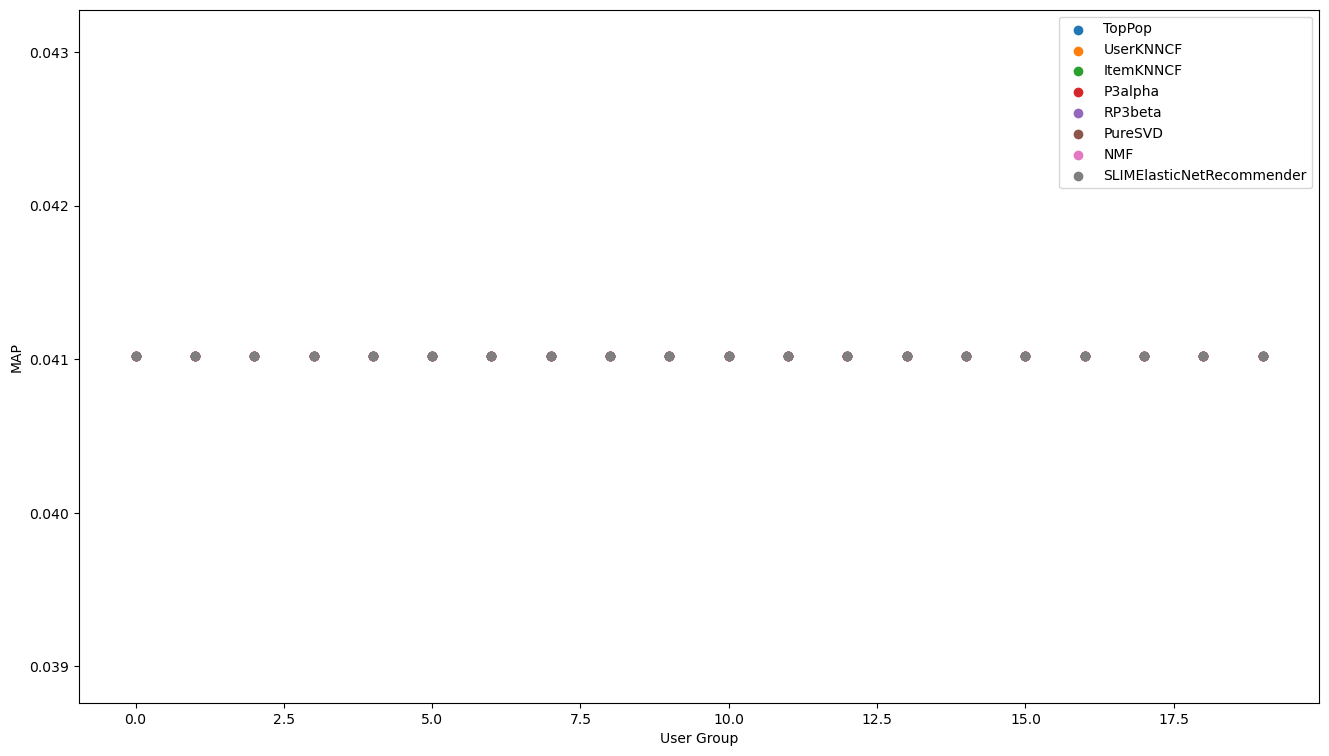

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline  

_ = plt.figure(figsize=(16, 9))
for label, recommender in recommender_object_dict.items():
    results = MAP_recommender_per_group["SLIMElasticNetRecommender"]
    plt.scatter(x=np.arange(0,len(results)), y=results, label=label)
plt.ylabel('MAP')
plt.xlabel('User Group')
plt.legend()
plt.show()